In [1]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats
import backtrader.indicators as btind
import quantstats as qs
import numpy as np

In [1]:
import sys

sys.path.append( '../../../utils' )
from data_manipulation import add_adj_close

In [28]:
min_data = pd.read_csv('../../../Data/Nifty/nifty_15min.csv')
daily_data = pd.read_csv('../nifty_daily_continous.csv')

In [29]:
adj = add_adj_close(min_data,daily_data)

In [30]:
adj.to_csv('nifty_15min_data.csv')

In [2]:
class OpeningRangeBreakout(bt.Strategy):
    params = dict(
        num_opening_bars=15
    )

    def __init__(self):
        self.opening_range_low = 0
        self.opening_range_high = 0
        self.opening_range = 0
        self.bought_today = False
        self.order = None
    
    def log(self, txt, dt=None):
        if dt is None:
            dt = self.datas[0].datetime.datetime()

        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            order_details = f"{order.executed.price}, Cost: {order.executed.value}, Comm {order.executed.comm}"

            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order_details}")
            else:  # Sell
                self.log(f"SELL EXECUTED, Price: {order_details}")
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        current_bar_datetime = self.data.num2date(self.data.datetime[0])
        previous_bar_datetime = self.data.num2date(self.data.datetime[-1])

        if current_bar_datetime.date() != previous_bar_datetime.date():
            self.opening_range_low = self.data.low[0]
            self.opening_range_high = self.data.high[0]
            self.bought_today = False
        
        opening_range_start_time = datetime.time(9, 30, 0)
        dt = datetime.datetime.combine(datetime.date.today(), opening_range_start_time) + datetime.timedelta(minutes=self.p.num_opening_bars)
        opening_range_end_time = dt.time()

        if current_bar_datetime.time() >= opening_range_start_time \
            and current_bar_datetime.time() < opening_range_end_time:           
            self.opening_range_high = max(self.data.high[0], self.opening_range_high)
            self.opening_range_low = min(self.data.low[0], self.opening_range_low)
            self.opening_range = self.opening_range_high - self.opening_range_low
        else:
            if self.order:
                return
            
            if self.position and (self.data.close[0] > (self.opening_range_high + self.opening_range)):
                self.close()
                
            if self.data.close[0] > self.opening_range_high and not self.position and not self.bought_today:
                self.order = self.buy()
                self.bought_today = True

            if self.position and (self.data.close[0] < (self.opening_range_high - self.opening_range)):
                self.order = self.close()

            if self.position and current_bar_datetime.time() >= datetime.time(15, 45, 0):
                self.log("RUNNING OUT OF TIME - LIQUIDATING POSITION")
                self.close()

    def stop(self):
        self.log('(Num Opening Bars %2d) Ending Value %.2f' %
                 (self.params.num_opening_bars, self.broker.getvalue()))

        if self.broker.getvalue() > 130000:
            self.log("*** BIG WINNER ***")

        if self.broker.getvalue() < 70000:
            self.log("*** MAJOR LOSER ***")

2011-01-13 23:59:59.999989, BUY EXECUTED, Price: 5857.34, Cost: 95637.6014258485, Comm 0.0
2011-01-13 23:59:59.999989, RUNNING OUT OF TIME - LIQUIDATING POSITION
2011-01-14 23:59:59.999989, SELL EXECUTED, Price: 5753.34, Cost: 95637.6014258485, Comm 0.0
2011-01-14 23:59:59.999989, SELL EXECUTED, Price: 5753.34, Cost: -93939.50799977314, Comm 0.0
2011-01-14 23:59:59.999989, RUNNING OUT OF TIME - LIQUIDATING POSITION
2011-01-17 23:59:59.999989, BUY EXECUTED, Price: 5652.89, Cost: -93939.50799977314, Comm 0.0
2011-01-17 23:59:59.999989, BUY EXECUTED, Price: 5652.89, Cost: 92299.378339684, Comm 0.0
2011-01-17 23:59:59.999989, RUNNING OUT OF TIME - LIQUIDATING POSITION
2011-01-18 23:59:59.999989, SELL EXECUTED, Price: 5684.13, Cost: 92299.378339684, Comm 0.0
2011-01-18 23:59:59.999989, SELL EXECUTED, Price: 5684.13, Cost: -92809.4594803628, Comm 0.0
2011-01-18 23:59:59.999989, RUNNING OUT OF TIME - LIQUIDATING POSITION
2011-01-19 23:59:59.999989, BUY EXECUTED, Price: 5741.41, Cost: -92809.4

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


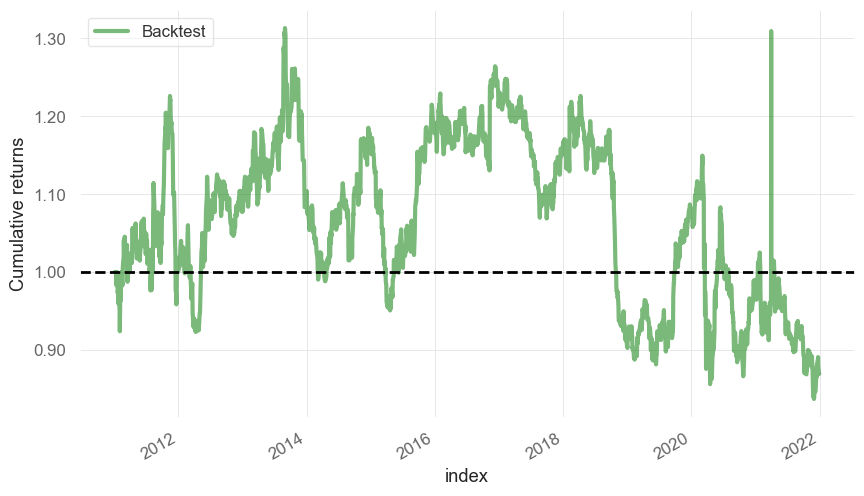

In [3]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

    data = bt.feeds.YahooFinanceCSVData(
        dataname='../nifty_15min_data.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2021, 12, 31),
        # Do not pass values after this date
        reverse=False)

    cerebro.adddata(data)
    cerebro.addstrategy(OpeningRangeBreakout)

    #strats = cerebro.optstrategy(OpeningRangeBreakout, num_opening_bars=[15, 30, 60])

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)

    quantstats.reports.html(returns, output='stats.html', title='Nifty ORB')
    '''data = cerebro.plot()
    data[0][0].savefig("orb.png")'''

    pf.plotting.plot_rolling_returns(returns)
    #cerebro.plot()